# Caricamenti dei pacchetti


In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'pdfminer', 'pyldavis', 'wordcloud','mglearn' }
missing = required - installedPackages
if missing:
    !pip install pdfminer==20191125
    !pip install pyLDAvis==2.1.2
    !pip install wordcloud==1.6.0
    !pip install mglearn==0.1.7

#librerie per la conversione di pdf
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
from io import StringIO

#librerie per l'estrazione delle features e topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

#altre librerie
import numpy as np
import pandas as pd

# Preparazione dei dati

In [ ]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

Nel passaggio successivo, il PDF viene convertito in testo utilizzando la funzione precedente e salvato in un file di testo:

In [ ]:
from google.colab import files
#per caricare il file pdf
uploaded = files.upload()

Document=convert_pdf_to_txt('10K.pdf')
f=open('Finance10k.txt','w')
f.write(Document)
f.close()
with open('Finance10k.txt') as f:
    clean_cont = f.read().splitlines()

Saving 10K.pdf to 10K (1).pdf


In [ ]:
clean_cont[1:15]

[' ',
 '',
 'SECURITIES AND EXCHANGE COMMISSION',
 ' ',
 '',
 'Washington, D.C. 20549',
 ' ',
 '',
 '\xa0',
 'FORM ',
 '\xa0',
 '',
 'QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF',
 ' ']

La seguente funzione utilizza una serie di ricerche di espressioni regolari ( regex ) e la comprensione dell'elenco per sostituire i caratteri non informativi con uno spazio vuoto:

In [ ]:
doc=[i.replace('\xe2\x80\x9c', '') for i in clean_cont ]
doc=[i.replace('\xe2\x80\x9d', '') for i in doc ]
doc=[i.replace('\xe2\x80\x99s', '') for i in doc ]

docs = [x for x in doc if x != ' ']
docss = [x for x in docs if x != '']
financedoc=[re.sub("[^a-zA-Z]+", " ", s) for s in docss]

In [ ]:
financedoc[1:15]

['SECURITIES AND EXCHANGE COMMISSION',
 'Washington D C ',
 ' ',
 'FORM ',
 ' ',
 'QUARTERLY REPORT PURSUANT TO SECTION OR d OF',
 'THE SECURITIES EXCHANGE ACT OF ',
 'For the quarterly period ended September ',
 'Commission file number ',
 ' ',
 ' ',
 'WELLS FARGO COMPANY ',
 ' Exact name of registrant as specified in its charter ',
 'Delaware ']

# Costruzione del modello e addestramento

In [ ]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
fin=vect.fit_transform(financedoc)
pd.DataFrame(fin.toarray(),columns=vect.get_feature_names_out()).head(1)

,aa,aaa,abbot,ability,able,abs,absorb,absorbed,absorbing,abusive,...,years,yes,yield,yielding,yields,york,yrs,zealand,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
lda=LatentDirichletAllocation(n_components=5)
lda.fit_transform(fin)
lda_dtf=lda.fit_transform(fin)

In [ ]:
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names_out())

In [ ]:
# il seguente è il codice aggiunto in modo che i nomi delle colonne I nomi degli argomenti in mglearn inizino con 1,
# se questo codice non viene aggiunto i nomi degli argomenti iniziano con 0 e c'è un disallineamento nei nomi degli argomenti
# dall'output di pyLDAvis nella sezione successiva.
array=np.full((1, sorting.shape[1]), 1)
array = np.concatenate((array,sorting), axis=0)

Il codice seguente utilizza la libreria mglearn per visualizzare le prime 10 parole all'interno di ogni specifico topic model

In [ ]:
import mglearn
topics = mglearn.tools.print_topics(topics=range(1,6), feature_names=features,
sorting=array, topics_per_chunk=5, n_words=10)

TypeError: ignored

# Visualizzazione degli argomenti

In [ ]:
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn
zit=pyLDAvis.sklearn.prepare(lda,fin,vect)
pyLDAvis.display(zit)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


ImportError: ignored

# Word Cloud

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

d = path.dirname(__name__)
text = open(path.join(d, 'Finance10k.txt')).read()
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


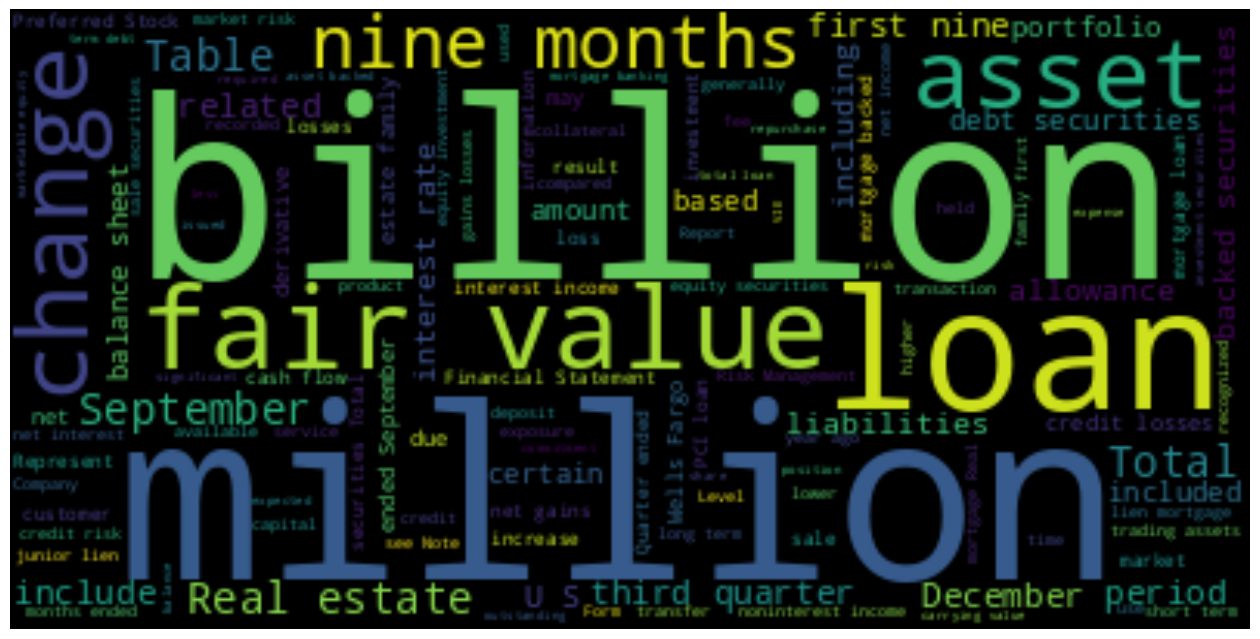

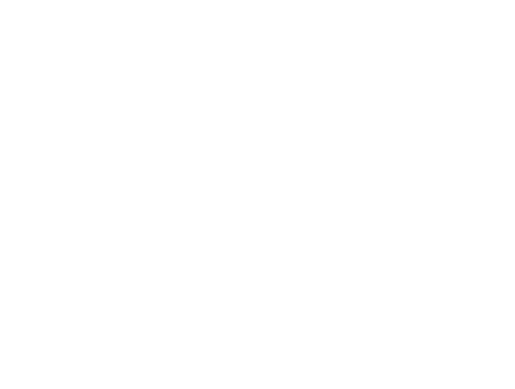

In [ ]:
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(raw_pic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()